# Project: ACME Customer Satisfaction survey
 
The goal of this notebook is to achieve an f1 score of .73 or higher for a model on prediction with this dataset. There is room for discussion on whether or not the intended performance was actually achieved.
 
This notebook assumes the reader a simple understanding of means, standard deviations, linear relationships, and models. Any concept more complex will be explained in the notes.


<a id="toc"></a>
## Table of contents:
1. [EDA](#part-one)
2. [Function definitions](#part-two)
3. [Cross validation results](#part-three)
4. [Single train/test split performance](#part-four)
5. [Model interpretations](#part-five)
6. [Conclusion](#part-six)

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/My Drive/upziva/ACME-HappinessSurvey2020.csv')
# data = data.drop_duplicates()
display(data.head())
print(data.shape)

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


(126, 7)


<a id="part-one"></a>
## Part 1: EDA
The exploratory data analysis is brief. All I'm looking for is a significant linear relationship (in the heatmap you will notice there are not any) and for any separability in the dataset (the pairplot will show some small amounts). There are only outliers in the X1 and X6 section of the dataset, and based on the range of the data I would not consider them large enough to be worth treating.

[Return to Table of Contents](#toc)

In [2]:
data.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


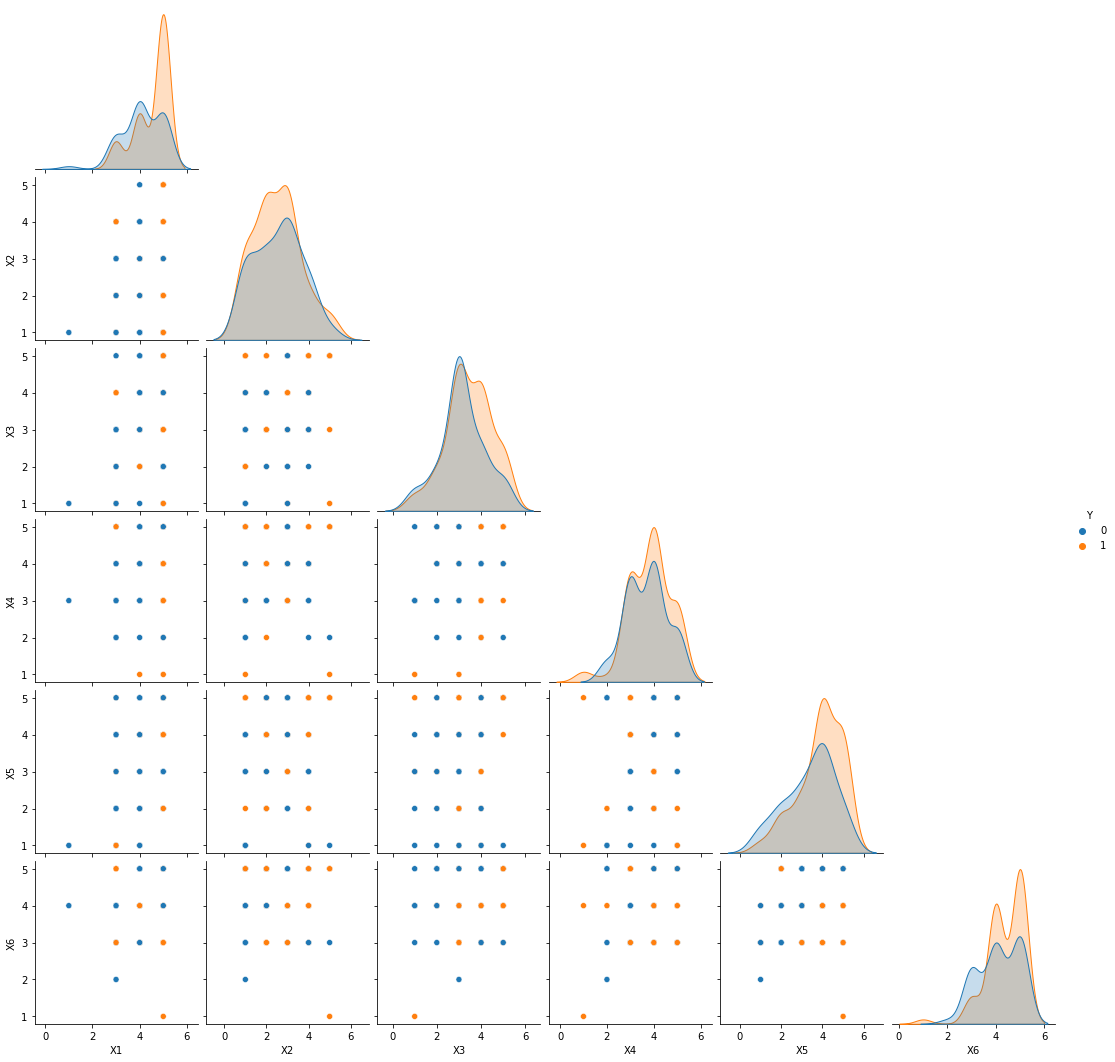

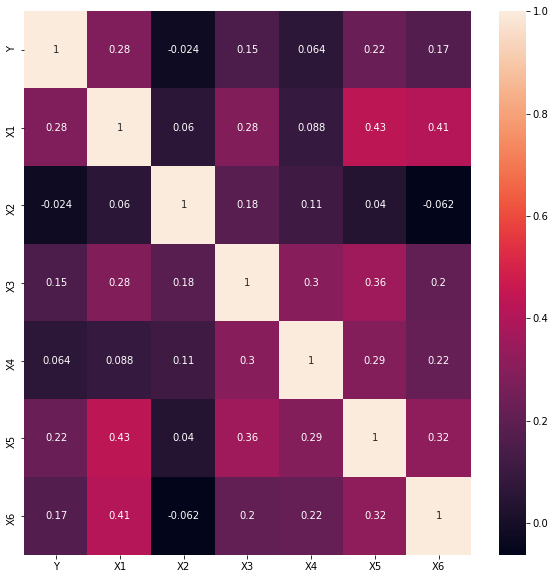

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(data, hue='Y', corner=True)

####

plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True);

<a id="part-two"></a>
 
## Part 2: Preprocessing and Function definitions
 
Below I split the data and create three functions. There is also commented out code with various preprocessing methods. My initial hypothesis was that no amount of preprocessing was needed (none of the outliers are extreme and there is a very specific range to the data). After testing with the methods below (and also removing duplicates) my hypothesis has not been disproven.
 
The `model_test function` trains a model on a single split of the dataset and displays the resulting f1 score for both the training data and the test data (optionally it will also produce a confusion matrix).
 
The `kfold_eval_model` function performs a cross fold evaluation on *n* number of splits of the data and stores the relevant values to a dataframe. The four values are the average f1 score across all splits for training data, again for test data, the standard deviation for the scores in the training performance and also for the test performance as well.
 
The `permutation_importance` function is a bit more special. This function I originally wrote for the ODSC 2020 Data Science Hackathon, which I got second place in (see https://github.com/Neil-Kloper/ODSC-Competition/blob/master/ODSC_SKLearn.ipynb for the full notebook). Essentially this function takes a model and a dataset, it will iterate through each column in the dataset, randomizing the contents, and then training the model on it and seeing the effect on performance. Due to the random nature of this method, the change in performance won't always perfectly match the amount of signal a particular feature is adding (so you have a range of uncertainty). The size of the dataset is inversely proportional to the range of uncertainty this method has. So the results of this function should be taken with a grain of salt in this context.


[Return to Table of Contents](#toc)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from itertools import combinations


# rscaler = RobustScaler()
# scaler = StandardScaler()
# poly = PolynomialFeatures()


### Additive feature generation
# cols = data.drop('Y', axis=1).columns
# for v in combinations(cols, 2):
#   data[str(v[0]+v[1])] = data[v[0]] + data[v[1]]
X = np.array(data.drop('Y', axis=1))
# X = rscaler.fit_transform(X)
# X = scaler.fit_transform(X)
# X = poly.fit_transform(X)
y = data['Y']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [5]:
# from itertools import combinations
# data_2 = data.copy()
# cols = data.drop('Y', axis=1).columns
# _ = [1,2,3]

# for v in combinations(cols, 2):
#   data_2[str(v[0]+v[1])] = data_2[v[0]] + data_2[v[1]]
# data_2.head()

In [6]:
# pd.DataFrame(X).describe()

In [7]:
from sklearn import metrics

def model_test(model, plot=False):
  """simple function to test out a model for this problem
  statement in a single line of code"""
  model.fit(x_train, y_train)
  score_1 = metrics.f1_score((model.predict(x_train)).round(), y_train)
  score_2 = metrics.f1_score((model.predict(x_test)).round(), y_test)
  print('Train F1 score for', model.__class__.__name__, 'is:', score_1)
  print('Test F1 score for', model.__class__.__name__, 'is:', score_2)
  if plot:
    metrics.plot_confusion_matrix(model, x_test, y_test)
    metrics.plot_confusion_matrix(model, x_train, y_train)

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

cols = ['Model', 'Mean train score', 'Train standard deviation', 'Mean test score', 'Test standard deviation']
model_performance = pd.DataFrame(columns=cols)

def kfold_eval_model(model, update_df=True):
  """simple function to test out a model for this problem
  statement in a single line of code,
  prints out the f1 score for training and testing data
  based on results from an n-fold cross validation
  saves results to a dataframe.
  will round predictions for regression to use for f1 evaluation.
  Takes an sklearn model as the first argument,
  second argument determines if the performance dataframe is updated"""
  global model_performance
  train_f1 = np.array([], dtype='float')
  test_f1 = np.array([], dtype='float')
  for train_index, test_index in kf.split(X):
    model.fit(X[train_index], y[train_index])
    score_1 = metrics.f1_score(y[train_index], abs((model.predict(X[train_index])).round()))
    score_2 =  metrics.f1_score(y[test_index], abs((model.predict(X[test_index])).round()))
    train_f1 = np.append(train_f1, score_1)
    test_f1 = np.append(test_f1, score_2)
  print(model.__class__.__name__)
  train_stats = (train_f1.mean(), train_f1.std())
  test_stats = (test_f1.mean(), test_f1.std())
  print('Average train f1 score across ', kf.get_n_splits(X),' folds:', train_stats[0], 'with a standard diviation of',train_stats[1])    
  print('Average test f1 score across ', kf.get_n_splits(X),' folds:', test_stats[0], 'with a standard diviation of', test_stats[1])
  if update_df:
    s = np.array([[model.__class__.__name__, train_stats[0],  train_stats[1], test_stats[0],  test_stats[1]]])
    s = pd.DataFrame(s)
    s.columns = cols
    model_performance = model_performance.append(s)

In [9]:
model_aucroc_performance = pd.DataFrame(columns=cols)

def roc_it(model, update_df=True):
  """Same as kfold_eval_model except it stores 
  the aucroc scores"""
  global model_aucroc_performance
  train_f1 = np.array([], dtype='float')
  test_f1 = np.array([], dtype='float')
  for train_index, test_index in kf.split(X):
    model.fit(X[train_index], y[train_index])
    try:
      score_1 = metrics.roc_auc_score(y[train_index], model.predict_proba(X[train_index])[:,1])
      score_2 =  metrics.roc_auc_score(y[test_index], model.predict_proba(X[test_index])[:,1])
    except:
      score_1 = metrics.roc_auc_score(y[train_index], model.predict(X[train_index]))
      score_2 =  metrics.roc_auc_score(y[test_index], model.predict(X[test_index]))
    train_f1 = np.append(train_f1, score_1)
    test_f1 = np.append(test_f1, score_2)
  print(model.__class__.__name__)
  train_stats = (train_f1.mean(), train_f1.std())
  test_stats = (test_f1.mean(), test_f1.std())
  print('Average train roc auc score across ', kf.get_n_splits(X),' folds:', train_stats[0], 'with a standard diviation of',train_stats[1])    
  print('Average test roc auc score across ', kf.get_n_splits(X),' folds:', test_stats[0], 'with a standard diviation of', test_stats[1])
  if update_df:
    s = np.array([[model.__class__.__name__, train_stats[0],  train_stats[1], test_stats[0],  test_stats[1]]])
    s = pd.DataFrame(s)
    s.columns = cols
    model_aucroc_performance = model_aucroc_performance.append(s)

In [10]:
## this function is an updated version of the code from: https://github.com/Neil-Kloper/ODSC-Competition/blob/master/ODSC_SKLearn.ipynb

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
rfr= RandomForestRegressor()


def permutation_importance(df, target_cols, perc=1., model=rfr, rs=42, metric=roc_auc_score, print_status=False):
  """This function uses permutation feature importance to rank features by relevance
  Only dependencies are SKLearn"""
  df = df.loc[:int(len(df)*perc)]
  cols = df.columns
  X_cols = [x for x in cols if (x not in target_cols)]
  dict_out = {}
  
  X = df[X_cols]
  y = df[target_cols]
  train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=rs)
  model.fit(train_X, train_y)
  try:
    ls_preds = model.predict_proba(val_X)[:,1]
  except:
    ls_preds = model.predict(val_X)
  try:
    baseline = metric(val_y, ls_preds)
  except:
    baseline = metric(val_y, ls_preds.round())
  dict_out['baseline'] = baseline
  if print_status:
    print('Baseline:', baseline)

  counter = 1
  for col in X_cols:
    t_df = df.copy()
    t_df[col] = np.random.permutation(t_df[col].values)
    
    X = t_df[X_cols]
    y = t_df[target_cols]
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(train_X, train_y)
    try:
      ls_preds = model.predict_proba(val_X)[:,1]
    except:
      ls_preds = model.predict(val_X)
    try:
      _aucroc = baseline - metric(val_y, ls_preds) 
    except:
      _aucroc = baseline - metric(val_y, ls_preds.round())
    dict_out[col] = _aucroc
    if print_status:
      print('column', counter, 'of', len(X_cols),',', col, 'has a score of', round(_aucroc, 4))
    counter+=1
  return pd.DataFrame(pd.Series(dict_out).sort_values(ascending=False))


## Part 2 and a half: model testing
Below I have several models that were tested, some performed well, others not so. This section can be safely skipped with nothing missed (other than hyperparameters). Not included in this notebook is the grid-search used to find the optimal hyperparameters.


In [11]:
from sklearn.linear_model import Lasso
las = Lasso()
kfold_eval_model(las)
las = Lasso()
roc_it(las)

Lasso
Average train f1 score across  5  folds: 0.7072023024721226 with a standard diviation of 0.027219721777343178
Average test f1 score across  5  folds: 0.6997160376173422 with a standard diviation of 0.1120296299070614
Lasso
Average train roc auc score across  5  folds: 0.5 with a standard diviation of 0.0
Average test roc auc score across  5  folds: 0.5 with a standard diviation of 0.0


In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=12, random_state=42)
model_test(rfc)
print('')
kfold_eval_model(rfc)
rfc = RandomForestClassifier(max_depth=12, random_state=42)
roc_it(rfc)

Train F1 score for RandomForestClassifier is: 0.9514563106796117
Test F1 score for RandomForestClassifier is: 0.6511627906976745

RandomForestClassifier
Average train f1 score across  5  folds: 0.9575695539330754 with a standard diviation of 0.008363776360891674
Average test f1 score across  5  folds: 0.5754071249065686 with a standard diviation of 0.043015320341424794
RandomForestClassifier
Average train roc auc score across  5  folds: 0.9930358395478722 with a standard diviation of 0.002175624531374759
Average test roc auc score across  5  folds: 0.5492752345693523 with a standard diviation of 0.07518989867838913


In [13]:
#this cell is a sanitiy check to make sure that I'm not getting wildly off results from my functions

from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(random_state=42)
rfr.fit(x_train, y_train)
preds = rfr.predict(x_test)
metrics.f1_score(preds, y_test)
metrics.accuracy_score(preds, y_test)

0.6052631578947368

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
# model_test(gbc)
kfold_eval_model(gbc)

gbc = GradientBoostingClassifier()
roc_it(gbc)

GradientBoostingClassifier
Average train f1 score across  5  folds: 0.9221257650140059 with a standard diviation of 0.015850941848178896
Average test f1 score across  5  folds: 0.6361327561327561 with a standard diviation of 0.048414846738268486
GradientBoostingClassifier
Average train roc auc score across  5  folds: 0.9744594552847575 with a standard diviation of 0.010228692067009857
Average test roc auc score across  5  folds: 0.5659119475295945 with a standard diviation of 0.12478124812687111


In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.6, penalty= 'l1', solver= 'liblinear', tol= 0.0005)
# model_test(lr)
kfold_eval_model(lr)
lr = LogisticRegression(C=0.6, penalty= 'l1', solver= 'liblinear', tol= 0.0005)
roc_it(lr)

LogisticRegression
Average train f1 score across  5  folds: 0.7100503691291509 with a standard diviation of 0.04207986000236754
Average test f1 score across  5  folds: 0.6308839342188489 with a standard diviation of 0.083633310645831
LogisticRegression
Average train roc auc score across  5  folds: 0.6669227170636359 with a standard diviation of 0.04712916225236616
Average test roc auc score across  5  folds: 0.5209628198598788 with a standard diviation of 0.12827400973177425


In [16]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier()
kfold_eval_model(bc)
bc = BaggingClassifier()
roc_it(bc)

BaggingClassifier
Average train f1 score across  5  folds: 0.9296667602937061 with a standard diviation of 0.011327347476959326
Average test f1 score across  5  folds: 0.5290749863163656 with a standard diviation of 0.03936542640121787
BaggingClassifier
Average train roc auc score across  5  folds: 0.9817490596418729 with a standard diviation of 0.008554231471448289
Average test roc auc score across  5  folds: 0.5032032918062329 with a standard diviation of 0.0797747945802279


In [17]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(max_iter=1000, batch_size=20,  random_state=42)
kfold_eval_model(mlpc)

mlpc = MLPClassifier(max_iter=1000, batch_size=20,  random_state=42)
roc_it(mlpc)

MLPClassifier
Average train f1 score across  5  folds: 0.7229770229770229 with a standard diviation of 0.07483239911649442
Average test f1 score across  5  folds: 0.5447044458809165 with a standard diviation of 0.2345193738183944
MLPClassifier
Average train roc auc score across  5  folds: 0.7432559941372956 with a standard diviation of 0.05802948259295682
Average test roc auc score across  5  folds: 0.5387142269495211 with a standard diviation of 0.15557705072973313


In [18]:
from sklearn.svm import NuSVC

svmc = NuSVC(max_iter=50000)
kfold_eval_model(svmc)

svmc = NuSVC(max_iter=50000)
roc_it(svmc)

NuSVC
Average train f1 score across  5  folds: 0.8827915893658581 with a standard diviation of 0.010065125408085285
Average test f1 score across  5  folds: 0.5196403596403596 with a standard diviation of 0.09452820901624054
NuSVC
Average train roc auc score across  5  folds: 0.8627372484101639 with a standard diviation of 0.011872573392075241
Average test roc auc score across  5  folds: 0.470139256168668 with a standard diviation of 0.0875657915459412


In [19]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(max_depth = 2, min_samples_split= 6, n_estimators= 25)
kfold_eval_model(etc)

etc = ExtraTreesClassifier(max_depth = 2, min_samples_split= 6, n_estimators= 25)
roc_it(etc)

ExtraTreesClassifier
Average train f1 score across  5  folds: 0.7368248666530433 with a standard diviation of 0.03418037624550693
Average test f1 score across  5  folds: 0.5964162561576355 with a standard diviation of 0.0833135715525022
ExtraTreesClassifier
Average train roc auc score across  5  folds: 0.7513063415619455 with a standard diviation of 0.03402992615635292
Average test roc auc score across  5  folds: 0.6179807120983591 with a standard diviation of 0.15132717012869032


In [20]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=7)
kfold_eval_model(dtc)

dtc = DecisionTreeClassifier(max_depth=7)
roc_it(dtc)

DecisionTreeClassifier
Average train f1 score across  5  folds: 0.8835630592077232 with a standard diviation of 0.0179391916201561
Average test f1 score across  5  folds: 0.5764367816091955 with a standard diviation of 0.11248678061414254
DecisionTreeClassifier
Average train roc auc score across  5  folds: 0.9558905961666768 with a standard diviation of 0.008471006833070322
Average test roc auc score across  5  folds: 0.5721231791084732 with a standard diviation of 0.10031712526180447


In [21]:
from sklearn.gaussian_process import GaussianProcessClassifier

gpc = GaussianProcessClassifier()
kfold_eval_model(gpc)

gpc = GaussianProcessClassifier()
roc_it(gpc)

GaussianProcessClassifier
Average train f1 score across  5  folds: 0.9063566362754246 with a standard diviation of 0.01504519504221743
Average test f1 score across  5  folds: 0.5066235210840327 with a standard diviation of 0.08947009814638657
GaussianProcessClassifier
Average train roc auc score across  5  folds: 0.9465885109357337 with a standard diviation of 0.013712732807875787
Average test roc auc score across  5  folds: 0.44947389212095096 with a standard diviation of 0.12726057650561276


In [22]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
kfold_eval_model(gnb)

gnb = GaussianNB()
roc_it(gnb)

GaussianNB
Average train f1 score across  5  folds: 0.6431413645982158 with a standard diviation of 0.05542968031086681
Average test f1 score across  5  folds: 0.6266339436528535 with a standard diviation of 0.13161899107690309
GaussianNB
Average train roc auc score across  5  folds: 0.6755720908649914 with a standard diviation of 0.057625754163082375
Average test roc auc score across  5  folds: 0.6182684962096727 with a standard diviation of 0.19431380636948567


In [23]:
from sklearn.naive_bayes import CategoricalNB

cnb = CategoricalNB()
kfold_eval_model(cnb)

cnb = CategoricalNB()
roc_it(cnb)

CategoricalNB
Average train f1 score across  5  folds: 0.703598184364286 with a standard diviation of 0.02462385833163432
Average test f1 score across  5  folds: 0.6220042756399577 with a standard diviation of 0.07390771879656478
CategoricalNB
Average train roc auc score across  5  folds: 0.7441649515739663 with a standard diviation of 0.02142571907594222
Average test roc auc score across  5  folds: 0.625404252610135 with a standard diviation of 0.12613942716946508


In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
kfold_eval_model(knn)

knn = KNeighborsClassifier(n_neighbors=7)
roc_it(knn)

KNeighborsClassifier
Average train f1 score across  5  folds: 0.7142374574941052 with a standard diviation of 0.045889042972027554
Average test f1 score across  5  folds: 0.533117193439774 with a standard diviation of 0.1101412808597095
KNeighborsClassifier
Average train roc auc score across  5  folds: 0.7473340936662767 with a standard diviation of 0.056269154598309425
Average test roc auc score across  5  folds: 0.4864143209731445 with a standard diviation of 0.12625870561211838


In [25]:
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier()
kfold_eval_model(rc)
  # model_test(rc)

rc = RidgeClassifier()
roc_it(rc)

RidgeClassifier
Average train f1 score across  5  folds: 0.6816096246752097 with a standard diviation of 0.0479790142241699
Average test f1 score across  5  folds: 0.6052651093807935 with a standard diviation of 0.12384924452624525
RidgeClassifier
Average train roc auc score across  5  folds: 0.6062945748434908 with a standard diviation of 0.05471803361765047
Average test roc auc score across  5  folds: 0.5585485592838534 with a standard diviation of 0.13984965252196627


In [26]:
from sklearn.linear_model import BayesianRidge

brr = BayesianRidge()

kfold_eval_model(brr)
# model_test(brr)
brr = BayesianRidge()
roc_it(brr)

BayesianRidge
Average train f1 score across  5  folds: 0.7008023159636064 with a standard diviation of 0.026967117648673253
Average test f1 score across  5  folds: 0.6246090579794695 with a standard diviation of 0.08094762967690829
BayesianRidge
Average train roc auc score across  5  folds: 0.6863706913728984 with a standard diviation of 0.05529805532168222
Average test roc auc score across  5  folds: 0.6244959289076937 with a standard diviation of 0.18427068330068205


In [27]:
from sklearn.linear_model import ARDRegression
ardr = ARDRegression()
kfold_eval_model(ardr)
ardr = ARDRegression()
roc_it(ardr)

ARDRegression
Average train f1 score across  5  folds: 0.6953724114379852 with a standard diviation of 0.03353357209116576
Average test f1 score across  5  folds: 0.6293035835023664 with a standard diviation of 0.1167513531214658
ARDRegression
Average train roc auc score across  5  folds: 0.6950156304631433 with a standard diviation of 0.04699739248722875
Average test roc auc score across  5  folds: 0.611437663643546 with a standard diviation of 0.17917500091642732


In [28]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
kfold_eval_model(cnb)
cnb = ComplementNB()
roc_it(cnb)

ComplementNB
Average train f1 score across  5  folds: 0.595263745004267 with a standard diviation of 0.03469951695175468
Average test f1 score across  5  folds: 0.5266756232273473 with a standard diviation of 0.11783309386546004
ComplementNB
Average train roc auc score across  5  folds: 0.6164870050736065 with a standard diviation of 0.020428729181354303
Average test roc auc score across  5  folds: 0.5332313927902164 with a standard diviation of 0.11881895051537544


In [29]:
from sklearn.svm import SVC
svc = SVC()
kfold_eval_model(svc)
svc = SVC()
roc_it(svc)

SVC
Average train f1 score across  5  folds: 0.785275573312892 with a standard diviation of 0.028191199511012725
Average test f1 score across  5  folds: 0.6045530939648587 with a standard diviation of 0.06897512794068174
SVC
Average train roc auc score across  5  folds: 0.7257695032316989 with a standard diviation of 0.04684601046443671
Average test roc auc score across  5  folds: 0.5252194700724113 with a standard diviation of 0.08405608133242347


In [30]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
kfold_eval_model(linr)
linr = LinearRegression()
roc_it(linr)

LinearRegression
Average train f1 score across  5  folds: 0.6840894090417865 with a standard diviation of 0.048445231720898686
Average test f1 score across  5  folds: 0.6015869484612533 with a standard diviation of 0.12564479877131113
LinearRegression
Average train roc auc score across  5  folds: 0.7002680669553227 with a standard diviation of 0.05060090112150527
Average test roc auc score across  5  folds: 0.5981870253929077 with a standard diviation of 0.17653195075319206


<a id="part-three"></a>
## Part 3: Cross Validation results
Below we have the results for each of the models using cross-validation, listed in order based on the f1 score on the test data.
 
The top-performing model was Lasso regression (a model which focuses on regularization, to avoid overfitting), with an average f1 score of .699. Notice that the difference between the models training and test performance I very close, whereas most of the models overfit to some degree. There is also a smaller variance in score in the training set, but there is a greater variance on the score for the test set, so there will be many cases where the model performs better in testing than in training.


[Return to Table of Contents](#toc)

In [31]:
model_performance.sort_values('Mean test score', ascending=False)

,Model,Mean train score,Train standard deviation,Mean test score,Test standard deviation
0,Lasso,0.7072023024721226,0.027219721777343178,0.6997160376173422,0.1120296299070614
0,GradientBoostingClassifier,0.9221257650140059,0.015850941848178896,0.6361327561327561,0.048414846738268486
0,LogisticRegression,0.7100503691291509,0.04207986000236754,0.6308839342188489,0.083633310645831
0,ARDRegression,0.6953724114379852,0.03353357209116576,0.6293035835023664,0.1167513531214658
0,GaussianNB,0.6431413645982158,0.05542968031086681,0.6266339436528535,0.13161899107690309
0,BayesianRidge,0.7008023159636064,0.026967117648673253,0.6246090579794695,0.08094762967690829
0,CategoricalNB,0.703598184364286,0.02462385833163432,0.6220042756399577,0.07390771879656478
0,RidgeClassifier,0.6816096246752097,0.0479790142241699,0.6052651093807935,0.12384924452624525
0,SVC,0.785275573312892,0.028191199511012725,0.6045530939648587,0.06897512794068174
0,LinearRegression,0.6840894090417865,0.048445231720898686,0.6015869484612533,0.12564479877131113


Below we can see what the predictions from the lasso model look like. It predicts all outcomes as being positive. My guess is that due to the low sample size all coefficients get pushed to zero too easily.

In [32]:
las.predict(X).round()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [33]:
data.Y.value_counts()

1    69
0    57
Name: Y, dtype: int64

 
 Below We have a new dataframe that represents the area under the curve for the operator reciever characteristic (or ROC AUC for short). A similar metric to the f1 score, however, it evaluates the probabilities of a model output and not the model’s final decision). The key difference between the two is that it won't ever favor a model which only outputs a 1 or 0 (with the exception of an instance in which all outcomes happen to actually be 0 or 1).
 
A couple of interesting notes: the standard deviation in testing data versus training data is even greater across this metric. Also, many of the top-performing models in this section are Bayesian, in further testing, I discovered this set of models was impacted more by the section of the dataset it was exposed to and not so much by the hyperparameters.
 

In [34]:
model_aucroc_performance.sort_values('Mean test score', ascending=False)

,Model,Mean train score,Train standard deviation,Mean test score,Test standard deviation
0,CategoricalNB,0.7441649515739663,0.02142571907594222,0.625404252610135,0.12613942716946508
0,BayesianRidge,0.6863706913728984,0.05529805532168222,0.6244959289076937,0.18427068330068205
0,GaussianNB,0.6755720908649914,0.057625754163082375,0.6182684962096727,0.19431380636948567
0,ExtraTreesClassifier,0.7513063415619455,0.03402992615635292,0.6179807120983591,0.15132717012869032
0,ARDRegression,0.6950156304631433,0.04699739248722875,0.611437663643546,0.17917500091642732
0,LinearRegression,0.7002680669553227,0.05060090112150527,0.5981870253929077,0.17653195075319206
0,DecisionTreeClassifier,0.9558905961666768,0.008471006833070322,0.5721231791084732,0.10031712526180447
0,GradientBoostingClassifier,0.9744594552847575,0.010228692067009857,0.5659119475295945,0.12478124812687111
0,RidgeClassifier,0.6062945748434908,0.05471803361765047,0.5585485592838534,0.13984965252196627
0,RandomForestClassifier,0.9930358395478722,0.002175624531374759,0.5492752345693523,0.07518989867838913


<a id="part-four"></a>
## Part 4: Single train/test split performance


 Considering the variance in performance for most models (the standard deviation), there are many possible training/test splits where a model would recieve an f1 score of .73+, but they most likely would not be able to reproduce those results on new data.
 
Below we have three such models with varying levels of complexity, each using a different split of the data.


[Return to Table of Contents](#toc)

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5)
xtrain1 = x_train.copy()
rfc = RandomForestClassifier(n_estimators=20, max_depth=11, random_state=42)
model_test(rfc)

Train F1 score for RandomForestClassifier is: 0.924731182795699
Test F1 score for RandomForestClassifier is: 0.7659574468085107


In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=34)
xtrain2 = x_train.copy()
mlpc = MLPClassifier(max_iter=255, activation= 'tanh', hidden_layer_sizes=(147, 49, 7),  solver='adam', batch_size=24, random_state=42)
model_test(mlpc)

Train F1 score for MLPClassifier is: 0.8431372549019608
Test F1 score for MLPClassifier is: 0.761904761904762


In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=31)
xtrain3 = x_train.copy()
gbr = GradientBoostingClassifier(n_estimators=60, random_state=8)
model_test(gbr)

Train F1 score for GradientBoostingClassifier is: 0.9263157894736843
Test F1 score for GradientBoostingClassifier is: 0.7906976744186046


Below we have a very quick analysis of the differences in each of the training splits.

In [38]:
print('there are',len(pd.DataFrame(xtrain1)), 'total entries in each training set')
xtrain1 = pd.DataFrame(xtrain1)
xtrain2 = pd.DataFrame(xtrain2)
xtrain3 = pd.DataFrame(xtrain3)
print('set 1 contains', len(xtrain1)-len(xtrain1.drop_duplicates()), 'rows which are duplicates')
print('set 2 contains', len(xtrain2)-len(xtrain2.drop_duplicates()), 'rows which are duplicates')
print('set 3 contains', len(xtrain3)-len(xtrain3.drop_duplicates()), 'rows which are duplicates')
xtrain1 = xtrain1.drop_duplicates()
xtrain2 = xtrain2.drop_duplicates()
xtrain3 = xtrain3.drop_duplicates()
_ = (xtrain1.append(xtrain2, ignore_index=True))
print('set 1 and 2 have',len(_) - len(_.drop_duplicates()), 'rows in common')
_ = (xtrain1.append(xtrain3, ignore_index=True))
print('set 1 and 3 have',len(_) - len(_.drop_duplicates()), 'rows in common')
_ = (xtrain2.append(xtrain3, ignore_index=True))
print('set 2 and 3 have',len(_) - len(_.drop_duplicates()), 'rows in common')
print('There are',len((pd.DataFrame(X)).drop_duplicates())- len(((xtrain1.append(xtrain2, ignore_index=True)).append(xtrain3, ignore_index=True)).drop_duplicates()), 'unique rows in the full dataset which are not present in the 3 splits')

there are 88 total entries in each training set
set 1 contains 12 rows which are duplicates
set 2 contains 9 rows which are duplicates
set 3 contains 11 rows which are duplicates
set 1 and 2 have 56 rows in common
set 1 and 3 have 58 rows in common
set 2 and 3 have 58 rows in common
There are 0 unique rows in the full dataset which are not present in the 3 splits


<a id="part-five"></a>
## Part 5: Model interpretations
Here I will use feature importance and permutation importance to see which features matter most to our customers.
 
Below we have the feature importance for the random forest model. This model finds the most signal in the x2, x3, and x5 values.

[Return to Table of Contents](#toc)

In [39]:
for num in range(6):
  print(data.drop("Y", axis=1).columns[num], ':', rfc.feature_importances_[num])

X1 : 0.16381327357862832
X2 : 0.20602878606579025
X3 : 0.18001504708896884
X4 : 0.13605809238952865
X5 : 0.2075237415643067
X6 : 0.10656105931277726


Since Sci Kit Learn does not have feature importance built-in for the other two models, I will instead use permutation importance. Permutation   importance takes a model and a dataset, it then randomly shuffle one row at a time and measure the performance difference between iterations to determine which features are the most important for inference.
 
Below we have the permutation importance (using both auc_roc and f1) for the same random forest model. As mentioned before permutation importance can be affected by dataset size and since there is some conflict with the feature importance I imagine these results are far from conclusive.
 
Below, we see X4 and X1 as the two most impactful features. Whereas X2 and X6 are both within a range where their value could be happenstance.


In [40]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=11, random_state=42)
print('Permutation importance score based on f1:')
display(permutation_importance(data, 'Y', model=rfc, perc=1., rs=5,metric=metrics.f1_score, print_status=False))
print('Permutation importance score based on auc_roc:')
display(permutation_importance(data, 'Y', model=rfc, perc=1., rs=5, print_status=False))

Permutation importance score based on f1:


,0
baseline,0.765957
X2,0.244218
X5,0.214233
X6,0.194529
X1,0.145268
X3,0.123100
X4,0.045957


Permutation importance score based on auc_roc:


,0
baseline,0.707386
X1,0.119508
X5,0.086174
X4,0.080114
X3,0.077083
X6,-0.044129
X2,-0.068371


Below we can see that the multilayer perceptron net ranks X2 the highest and X1 the least signifigant.

In [41]:
mlpc = MLPClassifier(max_iter=255, activation= 'tanh', hidden_layer_sizes=(147, 49, 7),  solver='adam', batch_size=24, random_state=42)
print('Permutation importance score based on f1:')
display(permutation_importance(data, 'Y', model=mlpc, perc=1., rs=34,metric=metrics.f1_score, print_status=False))
print('Permutation importance score based on auc_roc:')
display(permutation_importance(data, 'Y', model=mlpc, perc=1., rs=34, print_status=False))

Permutation importance score based on f1:


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (255) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,0
baseline,0.761905
X6,0.245776
X4,0.228571
X3,0.216450
X1,0.190476
X5,0.169312
X2,0.155844


Permutation importance score based on auc_roc:


,0
baseline,0.713889
X6,0.265404
X4,0.259343
X3,0.180556
X5,0.156313
X1,0.022980
X2,-0.001263


Below the gradient boosting model seems to rate most options positively.

In [42]:
gbr = GradientBoostingClassifier(n_estimators=60, random_state=8)
print('Permutation importance score based on f1:')
display(permutation_importance(data, 'Y', model=gbr, perc=1., rs=31,metric=metrics.f1_score, print_status=False))
print('Permutation importance score based on auc_roc:')
display(permutation_importance(data, 'Y', model=gbr, perc=1., rs=31, print_status=False))

Permutation importance score based on f1:


,0
baseline,0.790698
X5,0.272179
X4,0.238974
X3,0.175313
X2,0.147841
X1,0.147841
X6,0.095046


Permutation importance score based on auc_roc:


,0
baseline,0.746377
X4,0.255468
X6,0.158498
X2,0.158498
X3,0.152437
X5,0.122134
X1,0.097892


<a id="part-six"></a>
## Part 6: Conclusion
Since there was a large range in performance using Kfold I would not consider any of the models I produced to realistically achieve the goal of a .73 or higher F1 score (one could debate whether they actually did or not, my hypothesis is that the top-performing models wouldn't generalize very well). Since each of the three top-performing models were trained on different splits of the data I am curious if together their blended predictions would be better than any individual model. There was not a great deal of conformity in the feature importance between each of the models, this may be an artifact of the small dataset or it could possibly be that each model is only seeing a portion of the big picture (like the blind men and the elephant).
 
I chose to limit the models I used to Sci Kit Learn models (to keep the scope of the project narrow). In hindsight, there are some deep learning approaches that I did not try but might have proven useful. There is an approach using transfer learning for tabular data which I'm still working on that may have been effective, but it requires further experimentation before I would trust it for this use-case.
 
This was more interesting than I initially anticipated. I don't typically work with datasets this small. Some of the functions I wrote for this particular project will probably be useful to reuse on some larger ones.
 
I'm curious about what opportunities for improvement I missed.


[Return to Table of Contents](#toc)